In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha

delphesDir = os.path.abspath("../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/04


# Set Delphes output files

In [2]:
inputFiles = {'noBias' : '../DMSimp_monojet_LO_1j/Events/run_01/noBias_delphes_events.root',
             'pT bias' : '../DMSimp_monojet_LO_1j/Events/run_02/pT100bias_delphes_events.root',
             'pT cut' : '../DMSimp_monojet_LO_1j/Events/run_03/pT100cut_delphes_events.root',
             '0 jet' : '../DMSimp_monojet_LO_0j/Events/run_01/noBias_delphes_events.root'}

# Load Model Parameters

In [3]:
parameters = {}
for label,file in inputFiles.items():
    banner = list(glob.glob(os.path.dirname(file)+'/*banner.txt'))
    if len(banner) != 1:
        print('%i banner files found for %s!' %(len(banner),label))
        break
    else:
        banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    xsecPB = eval(xroot.find('init').text.split()[-2])
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    mMed = pars.blocks['MASS'][55]
    mDM = pars.blocks['MASS'][52]
    gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
    gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
    gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
    gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    parameters[label] = {'xsec(pb)' : xsecPB, 'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV, cross-section = %1.3e pb' %(mMed,mDM,xsecPB))

noBias : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 2.627e-01 pb
pT bias : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 2.593e-01 pb
pT cut : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 7.273e-02 pb
0 jet : mMed = 2000.00 GeV, mDM = 1.00 GeV, cross-section = 3.551e-01 pb


# Load events, apply cuts and store relevant info

## Cuts

In [4]:
## jets
pTj1min = 100.
pTjmin = 25.
etamax = 2.4
## MET
minMET = 250.
## Electrons
pTmin_el = 10.
etamax_el = 2.5
nMax_el = 0
## Muons
pTmin_mu = 10.
etamax_mu = 2.4
nMax_mu = 0


In [5]:
pTj1 = {label : np.array([]) for label in inputFiles}
weights = {label : np.array([]) for label in inputFiles}
met = {label : np.array([]) for label in inputFiles}
dmPT = {label : np.array([]) for label in inputFiles}
njets = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0.0 for label in inputFiles}
cutFlow = {label : OrderedDict({'Electron Veto' : 0, 'Muon Veto' : 0, 'pTmiss cut': 0, 
                       'pT(j1) cut' : 0, 'deltaPhi cut' : 0}) for label in inputFiles}
 
for label,inputFile in inputFiles.items():

    f = ROOT.TFile(inputFile,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    parameters[label]['Events'] = nevts
    
    for ievt in range(nevts):    
        tree.GetEntry(ievt)        

        particles = tree.Particle
       
        # Get DM particles (gen level)
        dmList = []
        for ip in range(particles.GetEntries()):
            p = particles.At(ip)
            if abs(p.PID) != 52:
                continue
            if p.Status != 1:
                continue
            dmList.append(p)
            
        if len(dmList) !=2:
            # Skip events with Mediator -> j j
            continue
        jets = tree.Jet
        weight = tree.Event.At(0).Weight
        weight = weight/nevts
        totalweight[label] += weight

#         missingET = tree.MissingET.At(0)
        missingET = tree.GenMissingET.At(0)  # USE REAL MISSING ET!
        electrons = tree.Electron
        muons = tree.Electron
    
        # Filter electrons:
        electronList = []
        for iel in range(electrons.GetEntries()):
            electron = electrons.At(iel)
            if electron.PT < pTmin_el:
                continue
            if abs(electron.Eta) > etamax_el:
                continue
            electronList.append(electron)
        
        # Filter muons:
        muonList = []
        for imu in range(muons.GetEntries()):
            muon = muons.At(imu)
            if muon.PT < pTmin_mu:
                continue
            if abs(muon.Eta) > etamax_mu:
                continue
            muonList.append(muon)
            
        # Filter jets
        jetList = []
        for ijet in range(jets.GetEntries()):
            jet = jets.At(ijet)
            if jet.PT < pTjmin:
                continue
            if abs(jet.Eta) > etamax:
                continue
            jetList.append(jet)  
        jetList = sorted(jetList, key = lambda j: j.PT, reverse=True)    
        
        if len(jetList) > 0:
            deltaPhi = np.abs(jetList[0].Phi-missingET.Phi) 
        else:
            deltaPhi = 0.0

#         Apply cuts:
        ## Veto electrons
        if len(electronList) > nMax_el: continue  
        cutFlow[label]['Electron Veto'] += weight
        ## Veto muons
        if len(muonList) > nMax_mu: continue  
        cutFlow[label]['Muon Veto'] += weight
        ## Cut on MET
        if missingET.MET < minMET: continue              
        cutFlow[label]['pTmiss cut'] += weight
        ## Veto zero jet events
        if len(jetList) < 1 or jetList[0].PT < pTj1min: continue
        cutFlow[label]['pT(j1) cut'] += weight
        if deltaPhi < 0.5: continue
        cutFlow[label]['deltaPhi cut'] += weight            
        
        
        dmPT[label] = np.append(dmPT[label],np.sqrt((dmList[0].Px + dmList[1].Px)**2 
                                                    + (dmList[0].Py + dmList[1].Py)**2))
        
        # Store relevant data        
        pTj1[label] = np.append(pTj1[label],jetList[0].PT)
        weights[label] = np.append(weights[label],weight)
        met[label] = np.append(met[label],missingET.MET)
        njets[label] = np.append(njets[label],len(jetList))
        
f.Close()


### Total cross-sections

In [6]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb (%ik events)' %(w,parameters[label]['Events']/1e3))
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(weights.keys())}    

noBias total cross-section = 2.627e-01 pb (10k events)
pT bias total cross-section = 2.628e-01 pb (10k events)
pT cut total cross-section = 7.273e-02 pb (10k events)
0 jet total cross-section = 3.551e-01 pb (50k events)


### Cut flows

In [7]:
for label,cFlow in cutFlow.items():
    print(label,':')
    for cut,w in cFlow.items():
        print('\t %s : %1.3f' %(cut,w/totalweight[label]))

noBias :
	 Electron Veto : 1.000
	 Muon Veto : 1.000
	 pTmiss cut : 0.184
	 pT(j1) cut : 0.184
	 deltaPhi cut : 0.138
pT bias :
	 Electron Veto : 1.000
	 Muon Veto : 1.000
	 pTmiss cut : 0.192
	 pT(j1) cut : 0.192
	 deltaPhi cut : 0.149
pT cut :
	 Electron Veto : 1.000
	 Muon Veto : 1.000
	 pTmiss cut : 0.418
	 pT(j1) cut : 0.418
	 deltaPhi cut : 0.323
0 jet :
	 Electron Veto : 1.000
	 Muon Veto : 1.000
	 pTmiss cut : 0.086
	 pT(j1) cut : 0.085
	 deltaPhi cut : 0.066


### Distributions

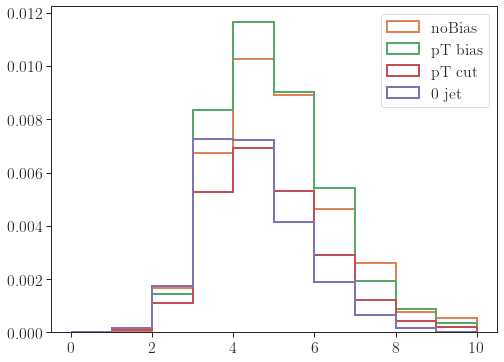

In [8]:
fig = plt.figure(figsize=(8,6))
for label,nj in njets.items():
    plt.hist(nj,bins=np.linspace(0,10,11),
             weights=weights[label],
             label=label,histtype='step',linewidth=2,color=colors[label])
# plt.yscale('log')
# plt.ylim(1e-5,1)
# plt.xlim(0,2000)
plt.legend()
plt.show()

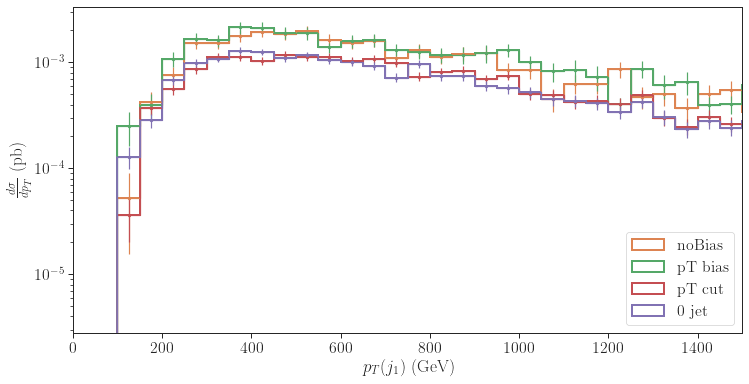

In [9]:
fig = plt.figure(figsize=(12,6))
for label,pt in pTj1.items():
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2)
    errorc2,_ = np.histogram(pt,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
    plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
                 drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-3,1)
plt.xlabel(r'$p_T(j_1)$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{dp_{T}}$ (pb)')
plt.xlim(0,1500)
plt.legend()
plt.show()

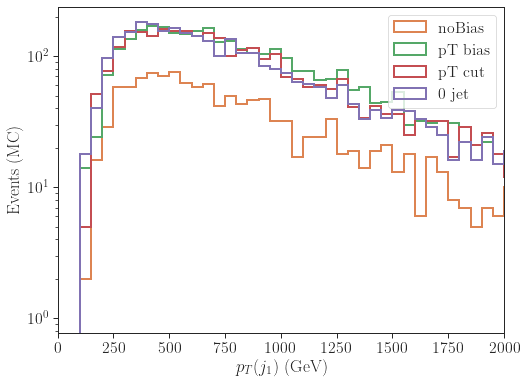

In [10]:
fig = plt.figure(figsize=(8,6))
for label,pt in pTj1.items():
    plt.hist(pt,bins=np.linspace(0,5000,101),color=colors[label],
             label=label,histtype='step',linewidth=2)
# plt.title(r'$p_T(DM) > %1.2f$' %min(dmPT))
# plt.vlines(x=100.,ymin=1e-10,ymax=1e3,color='red',linewidth=3)
plt.yscale('log')
plt.xlabel(r'$p_T(j_1)$ (GeV)')
plt.ylabel('Events (MC)')

plt.xlim(0,2000)
plt.legend()
plt.show()

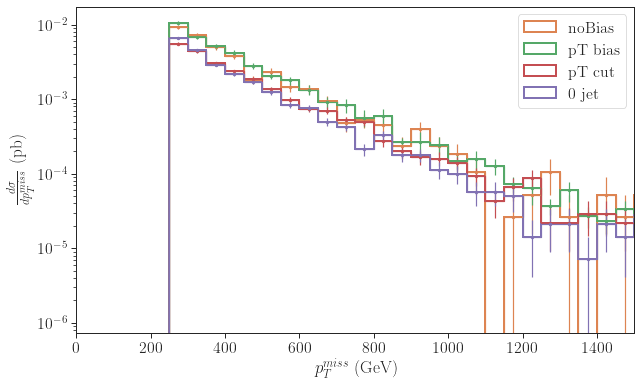

In [11]:
fig = plt.figure(figsize=(10,6))
for label,metPts in met.items():
    binc,binEdges,patches = plt.hist(metPts,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],
                               weights=weights[label],linewidth=2)
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weights[label]**2)
    errorc = np.sqrt(errorc2)
    binCenter = (binEdges[0:-1]+binEdges[1:])/2.
    plt.errorbar(binCenter,binc,yerr = errorc, marker = '.', 
                 drawstyle = 'steps-mid',color=colors[label])

    
plt.yscale('log')
# plt.ylim(1e-3,1)
plt.xlabel(r'$p_T^{miss}$ (GeV)')
plt.ylabel(r'$\frac{d\sigma}{d p_T^{miss}}$ (pb)')
plt.xlim(0,1500)
plt.legend()
plt.show()

# Get official CMS data

In [12]:
pickleFile = '../monoJet/CMS-EXO-20-004-data/Signaltemplates_DMsimp_spin-1_Monojet_DF.pcl'
df = pd.read_pickle(pickleFile)

### Filter model

In [13]:
if gAx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Axial")]
elif gVx:
    dfModel = df[(df["$m_{med}$"] == mMed) & (df["$m_{DM}$"] == mDM) 
                 & (df['Mode'] == 'DM+QCDjets') & (df['Data-takingperiod'] == 2017)
                 & (df["Coupling"] == "Vector")]

if len(dfModel) != 1:
    print('%i data rows selected' %(len(dfModel)))

In [14]:
bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if "bin_" in c}
cmsData = {c : dfModel[c].iloc[0] for c in bins}
rightBin = 2000.
binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()

# Plot CMS data
cmsValues = np.array(list(cmsData.values()))

## Plot Results

/tmp/ipykernel_47181/3872044658.py:23: RuntimeWarning: divide by zero encountered in divide
  relDiffErr = np.abs(binc-cmsValues)/errorc


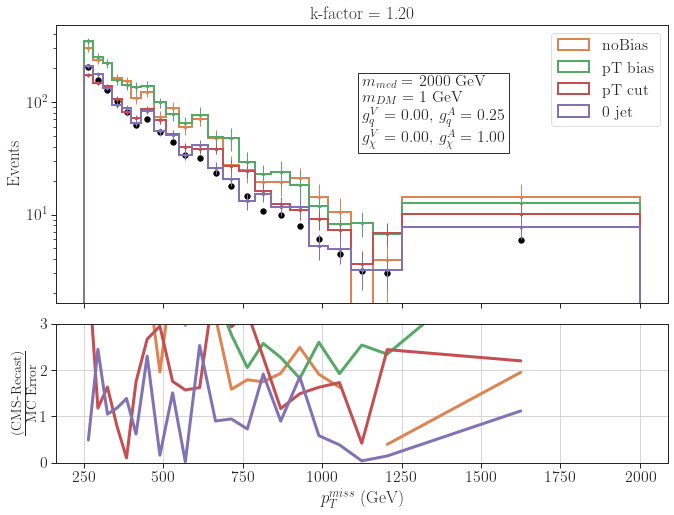

In [15]:
lum2017 = 41.5 #fb^-1
kfactor = 1.2 # NLO (approx) k-factor
weightY = {label : w*1e3*lum2017*kfactor for label,w in weights.items()} # weights for the Yield


f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

for label,metPts in met.items():
#     if label != 'noBias': continue
    # Plot MC bins
    binc,binEdges,_= axarr[0].hist(metPts,bins=list(bins.values())+[rightBin],
                                   label=label,linewidth=2,
                                   weights=weightY[label],histtype='step',color=colors[label])
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weightY[label]**2)
    errorc = np.sqrt(errorc2)
    axarr[0].errorbar(binCenter,binc,yerr = errorc, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color=colors[label],linewidth=0.0)

    
    relDiff = np.abs(binc-cmsValues)/cmsValues
    ratio = binc/cmsValues
    relDiffErr = np.abs(binc-cmsValues)/errorc
    #Plot ratio
    axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label])
    
    
# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
axarr[0].scatter(x=binCenter,y=cmsValues,s=30,c='black')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')


# axarr[1].axhline(y=1.)
axarr[1].set_ylim(0.0,3)
# axarr[1].set_yticks([0.25,0.5,0.75,1.0,1.25,1.5])
# axarr[1].set_yscale('log')
# axarr[1].set_ylabel('Relative Diff.', fontsize=18) #Y-label
axarr[1].set_ylabel(r'$\frac{\mbox{(CMS-Recast)}}{\mbox{MC Error}}$', fontsize=14) #Y-label
axarr[1].grid(True)
axarr[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')

#     axarr[0].set_title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f, k-factor = %1.2f' 
#               %(lum2017,list(cutFlow.values())[-1]/totalweight,kfactor))
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.5,2.3,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
axarr[0].legend()
axarr[0].set_title('k-factor = %1.2f' %kfactor)
plt.show()

/tmp/ipykernel_47181/2647704889.py:23: RuntimeWarning: divide by zero encountered in divide
  relDiffErr = np.abs(binc-cmsValues)/errorc


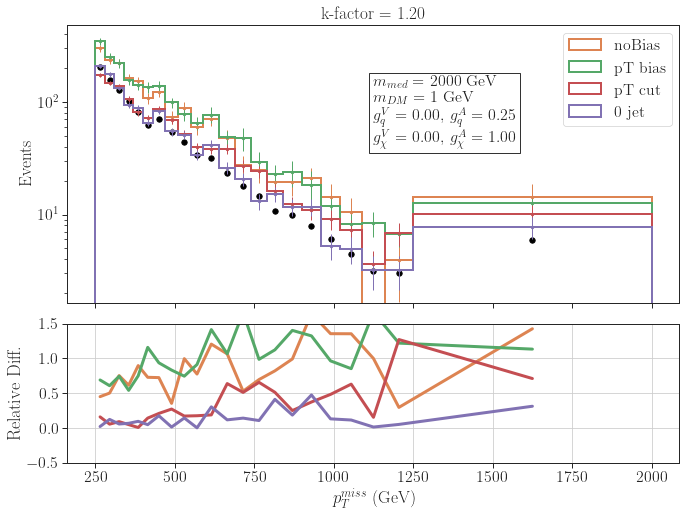

In [16]:
lum2017 = 41.5 #fb^-1
kfactor = 1.2 # NLO (approx) k-factor
weightY = {label : w*1e3*lum2017*kfactor for label,w in weights.items()} # weights for the Yield


f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

for label,metPts in met.items():
#     if label != 'noBias': continue
    # Plot MC bins
    binc,binEdges,_= axarr[0].hist(metPts,bins=list(bins.values())+[rightBin],
                                   label=label,linewidth=2,
                                   weights=weightY[label],histtype='step',color=colors[label])
    errorc2,_ = np.histogram(metPts,bins=binEdges,weights=weightY[label]**2)
    errorc = np.sqrt(errorc2)
    axarr[0].errorbar(binCenter,binc,yerr = errorc, marker = '.', elinewidth=1.0,
                 drawstyle = 'steps-mid',color=colors[label],linewidth=0.0)

    
    relDiff = np.abs(binc-cmsValues)/cmsValues
    ratio = binc/cmsValues
    relDiffErr = np.abs(binc-cmsValues)/errorc
    #Plot ratio
#     axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label])
    axarr[1].plot(binCenter,relDiff,linewidth=3.0,color=colors[label])
    
    
# Plot CMS data
cmsValues = np.array(list(cmsData.values()))
axarr[0].scatter(x=binCenter,y=cmsValues,s=30,c='black')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')


# axarr[1].axhline(y=1.)
axarr[1].set_ylim(-0.5,1.5)
# axarr[1].set_yticks([0.25,0.5,0.75,1.0,1.25,1.5])
# axarr[1].set_yscale('log')
axarr[1].set_ylabel('Relative Diff.', fontsize=18) #Y-label
# axarr[1].set_ylabel(r'$\frac{\mbox{(CMS-Recast)}}{\mbox{MC Error}}$', fontsize=14) #Y-label
axarr[1].grid(True)
axarr[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
axarr[0].set_title('k-factor = %1.2f' %kfactor)
#     axarr[0].set_title(r'$\mathcal{L} = %1.1f$ fb$^{-1}$ (2017), $\epsilon$(pre) = %1.3f, k-factor = %1.2f' 
#               %(lum2017,list(cutFlow.values())[-1]/totalweight,kfactor))
textstr = '\n'.join((
    r'$m_{med} =$ %1.0f GeV' %mMed, 
    r'$m_{DM} =$ %1.0f GeV' %mDM,
    r'$g_{q}^{V}=$ %1.2f, $g_{q}^{A}=$ %1.2f' % (gVq, gAq),
    r'$g_{\chi}^{V}=$ %1.2f, $g_{\chi}^{A}=$ %1.2f' % (gVx, gAx)))
plt.text(0.5,2.3,textstr,fontsize=16,bbox=dict(facecolor='none', edgecolor='black'),
         transform = plt.gca().transAxes)
axarr[0].legend()
plt.show()